In [1]:
import findspark
findspark.init()
from pyspark import SparkContext
sc=SparkContext()
sc

<SparkContext master=yarn appName=pyspark-shell>

In [2]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("noaa_map").getOrCreate()


In [3]:
spark

In [4]:
df = spark.read.option("header", "true").csv("s3://open-data-noaa/cleaneddata/*.csv")

In [5]:
# backup for further use
dfback=df

In [6]:
df.printSchema()

root
 |-- station: string (nullable = true)
 |-- date: string (nullable = true)
 |-- latitude: string (nullable = true)
 |-- longitude: string (nullable = true)
 |-- elevation: string (nullable = true)
 |-- wind: string (nullable = true)
 |-- cig: string (nullable = true)
 |-- vis: string (nullable = true)
 |-- temp: string (nullable = true)
 |-- dew: string (nullable = true)
 |-- slp: string (nullable = true)
 |-- liquid: string (nullable = true)
 |-- liqhr: string (nullable = true)
 |-- month: string (nullable = true)



In [9]:
# change data type
df = df.withColumn("cig",df["cig"].cast("float"))
df = df.withColumn("vis",df["vis"].cast("float"))
df = df.withColumn("liquid",df["liquid"].cast("float"))
df = df.withColumn("slp",df["slp"].cast("float"))
df = df.withColumn("temp",df["temp"].cast("float"))
df = df.withColumn("wind",df["wind"].cast("float"))


In [10]:
df.printSchema()

root
 |-- station: string (nullable = true)
 |-- date: string (nullable = true)
 |-- latitude: string (nullable = true)
 |-- longitude: string (nullable = true)
 |-- elevation: string (nullable = true)
 |-- wind: float (nullable = true)
 |-- cig: float (nullable = true)
 |-- vis: float (nullable = true)
 |-- temp: float (nullable = true)
 |-- dew: string (nullable = true)
 |-- slp: float (nullable = true)
 |-- liquid: float (nullable = true)
 |-- liqhr: float (nullable = true)
 |-- month: string (nullable = true)



In [145]:
df.show(2)

+-----------+-------------------+--------+---------+---------+----+-----+-------+----+-----+------+------+-----+-----+
|    station|               date|latitude|longitude|elevation|wind|  cig|    vis|temp|  dew|   slp|liquid|liqhr|month|
+-----------+-------------------+--------+---------+---------+----+-----+-------+----+-----+------+------+-----+-----+
|72549094933|2019-01-01T00:56:00|   42.55|-94.18333|    352.3| 5.7|335.0|14484.0|-5.6| -7.8|1020.2|   0.0|  1.0|    1|
|72549094933|2019-01-01T01:56:00|   42.55|-94.18333|    352.3| 5.7|396.0|16093.0|-7.8|-10.0|1022.7|   0.0|  1.0|    1|
+-----------+-------------------+--------+---------+---------+----+-----+-------+----+-----+------+------+-----+-----+
only showing top 2 rows



In [123]:
from pyspark.sql.functions import *

In [146]:
# groupby stations' temp info
comp = df.groupBy("station","latitude","longitude",'elevation').agg(mean('temp'),max('temp'),min("temp")
                                                        ,mean('wind'),max('wind'),min("wind")
                                                       ,mean('cig'),max('cig'),min("cig")
                                                       ,mean('vis'),max('vis'),min("vis")
                                                       ,mean('liqhr'),max('liqhr'),min("liqhr")
                                                       ,mean('liquid'),max('liquid'),min("liquid")
                                                       ,mean('slp'),max('slp'),min("slp")
                                                       ,mean('dew'),max('dew'),min("dew")).alias('comp')


In [147]:
comp.head()

Row(station='02557099999', latitude='57.883335', longitude='15.866667', elevation='91.0', avg(temp)=6.158765328908726, max(temp)=29.799999237060547, min(temp)=-9.600000381469727, avg(wind)=3.242184407705368, max(wind)=10.0, min(wind)=0.0, avg(cig)=3258.943411159478, max(cig)=22000.0, min(cig)=30.0, avg(vis)=26175.532251681838, max(vis)=50000.0, min(vis)=700.0, avg(liqhr)=1.004352987732489, max(liqhr)=12.0, min(liqhr)=1.0, avg(liquid)=0.11722068402578602, max(liquid)=6.0, min(liquid)=0.0, avg(slp)=1006.5081909324607, max(slp)=1041.9000244140625, min(slp)=976.7999877929688, avg(dew)=2.151760981400874, max(dew)='9.9', min(dew)='-0.1')

In [149]:
# compute variation
comp=comp.withColumn('temp_diff', col("max(temp)") - col("min(temp)"))
comp=comp.withColumn('cig_diff', col("max(cig)") - col("min(cig)"))
comp=comp.withColumn('wind_diff', col("max(wind)") - col("min(wind)"))
comp=comp.withColumn('vis_diff', col("max(vis)") - col("min(vis)"))
comp=comp.withColumn('liq_diff', col("max(liquid)") - col("min(liquid)"))
comp=comp.withColumn('slp_diff', col("max(slp)") - col("min(slp)"))
comp=comp.withColumn('dew_diff', col("max(dew)") - col("min(dew)"))


In [150]:
comp.show(2)

+-----------+---------+---------+---------+------------------+---------+---------+------------------+---------+---------+-----------------+--------+--------+------------------+--------+--------+-----------------+----------+----------+-------------------+-----------+-----------+------------------+--------+--------+------------------+--------+--------+---------+--------+---------+--------+--------+---------+-------------------+
|    station| latitude|longitude|elevation|         avg(temp)|max(temp)|min(temp)|         avg(wind)|max(wind)|min(wind)|         avg(cig)|max(cig)|min(cig)|          avg(vis)|max(vis)|min(vis)|       avg(liqhr)|max(liqhr)|min(liqhr)|        avg(liquid)|max(liquid)|min(liquid)|          avg(slp)|max(slp)|min(slp)|          avg(dew)|max(dew)|min(dew)|temp_diff|cig_diff|wind_diff|vis_diff|liq_diff| slp_diff|           dew_diff|
+-----------+---------+---------+---------+------------------+---------+---------+------------------+---------+---------+-----------------+-

In [177]:
comp2=comp.select('station','latitude','longitude','elevation','avg(temp)',
                  'temp_diff','avg(wind)','wind_diff','avg(cig)','cig_diff',
                  'avg(vis)','vis_diff','avg(liquid)','liq_diff','avg(slp)',
                  'slp_diff','avg(dew)','dew_diff')
comp2.show(2)

+-----------+---------+---------+---------+------------------+---------+------------------+---------+-----------------+--------+------------------+--------+-------------------+--------+------------------+---------+------------------+-------------------+
|    station| latitude|longitude|elevation|         avg(temp)|temp_diff|         avg(wind)|wind_diff|         avg(cig)|cig_diff|          avg(vis)|vis_diff|        avg(liquid)|liq_diff|          avg(slp)| slp_diff|          avg(dew)|           dew_diff|
+-----------+---------+---------+---------+------------------+---------+------------------+---------+-----------------+--------+------------------+--------+-------------------+--------+------------------+---------+------------------+-------------------+
|02557099999|57.883335|15.866667|     91.0| 6.158765328908726|     39.4| 3.242184407705368|     10.0|3258.943411159478| 21970.0|26175.532251681838| 49300.0|0.11722068402578602|     6.0|1006.5081909324607| 65.10004| 2.151760981400874|     

In [157]:
#export data to s3 for further Spatial 
comp2.write.csv("s3://project/map_visluization/data_temp", sep=',', header=True,mode="overwrite")

### Load Data for Spatial visulization

Reference:
* Geospark:https://github.com/DataSystemsLab/GeoSpark/tree/master/python

In [158]:
# import library for geospark
from pyspark import StorageLevel
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation

import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
from shapely.geometry import Polygon
import mapclassify as mc
import matplotlib.pyplot as plt

from geospark.register import GeoSparkRegistrator
from geospark.register import upload_jars
from geospark.core.SpatialRDD import PointRDD
from geospark.core.enums import FileDataSplitter
from geospark.core.formatMapper.shapefileParser import ShapefileReader
from geospark.sql.types import GeometryType
from geospark.core.enums import GridType
from geospark.core.enums import IndexType
from geospark.core.geom.envelope import Envelope
from geospark.utils import GeoSparkKryoRegistrator, KryoSerializer

terminal steps:   
1. pip install geopandas  
2. pip install geospark  
3. pip install descartes
4. pip install mapclassify

In [178]:
upload_jars()

True


In [179]:
# import sparkseesion with config again
spark = SparkSession.\
    builder.\
    master("local[*]").\
    appName("GeoPySparkCoreExample").\
    config("spark.serializer", KryoSerializer.getName).\
    config("spark.kryo.registrator", GeoSparkKryoRegistrator.getName) .\
    getOrCreate()

In [183]:
GeoSparkRegistrator.registerAll(spark)

True


In [184]:
# read data by point rdd, which will auto merger the lat and lon to point for mapping
point_rdd = PointRDD(sc, "s3://project/map_visluization/data_temp/*", 1, FileDataSplitter.CSV, 
                     True, 10, StorageLevel.MEMORY_ONLY, "epsg:4326", "epsg:4326")

In [185]:
# Spatial partitioning data (I don't why, but followed the steps on geosparks doc)
point_rdd.spatialPartitioning(GridType.EQUALGRID)

True


In [190]:
comp2.count()

6846

In [191]:
# count rows 
point_rdd.approximateTotalCount
# same rows as comp2, data load correctly

6846


In [194]:
# take firs element
point_rdd.rawSpatialRDD.take(1)

[Geometry: Point userData: 23933099999   23.16   3.397260327249357   55.29999923706055   1.9726027397260273  5.0   19275.616438356163   21880.0   9664.383561643835   9500.0   0.0571917817762045   1.3333333730697632    1010.1438356164383   46.0999755859375   -1.5931506863195601   52.400001525878906]


In [189]:
# take firs element
point_rdd.rawSpatialRDD.take(1)

### Converting GeoSpark to GeoPandas

In [195]:
point_rdd_to_geo = point_rdd.rawSpatialRDD.map(lambda x: [x.geom, *x.getUserData().split("\t")])

gdf = gpd.GeoDataFrame(
    point_rdd_to_geo.collect(), columns=['elevation','tem_avg', 'tem_diff', 'wind_avg', 'wind_diff', 'cig_avg', 'cig_diff',
       'vis_avg', 'vis_diff', 'liq_avg', 'liq_diff', 'slp_avg', 'slp_diff', 'dew_avg', 'dew_diff',"geom"], geometry="geom"
)

In [206]:
gdf.head()

elevation    tem_avg   tem_diff  wind_avg  wind_diff       cig_avg  \
0      91.00   6.158765  39.400002  3.242184       10.0   3258.943411   
1     397.00  15.050000  18.599998  3.600000        6.7  11327.500000   
2     120.00   2.356849  61.699997  2.596292        9.0   4900.154480   
3      22.00  -1.404095  62.000000  3.463362        8.0   5239.676724   
4      23.16   3.397260  55.299999  1.972603        5.0  19275.616438   

   cig_diff       vis_avg  vis_diff   liq_avg  liq_diff      slp_avg  \
0   21970.0  26175.532252   49300.0  0.117221  6.000000  1006.508191   
1   22000.0  19925.000000   50000.0  0.000000  0.000000  1016.308334   
2   21940.0  33625.540680   49700.0  0.104094  1.166667  1008.082801   
3   21850.0  36742.456897   49200.0  0.091559  3.416667  1009.151507   
4   21880.0   9664.383562    9500.0  0.057192  1.333333  1010.143836   

    slp_diff    dew_avg  dew_diff                   geometry  
0  65.100037   2.151761      10.0  POINT (15.86667 57.88334)  
1  25.399963  11.033333      -2.3  POINT (10.40000 42.73333)  
2  66.000000  -0.459629      10.0  POINT (31.16667 65.21667)  
3  77.399963  -3.564871      10.1  POINT (52.55000 66.25000)  
4  46.099976  -1.593151       9.7  POINT (69.08607 61.02848)

In [303]:
gdf=gdf.dropna()

In [209]:
# load world map info
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

(-197.99999999999997, 198.00000000000006, -98.6822565, 92.3273865)

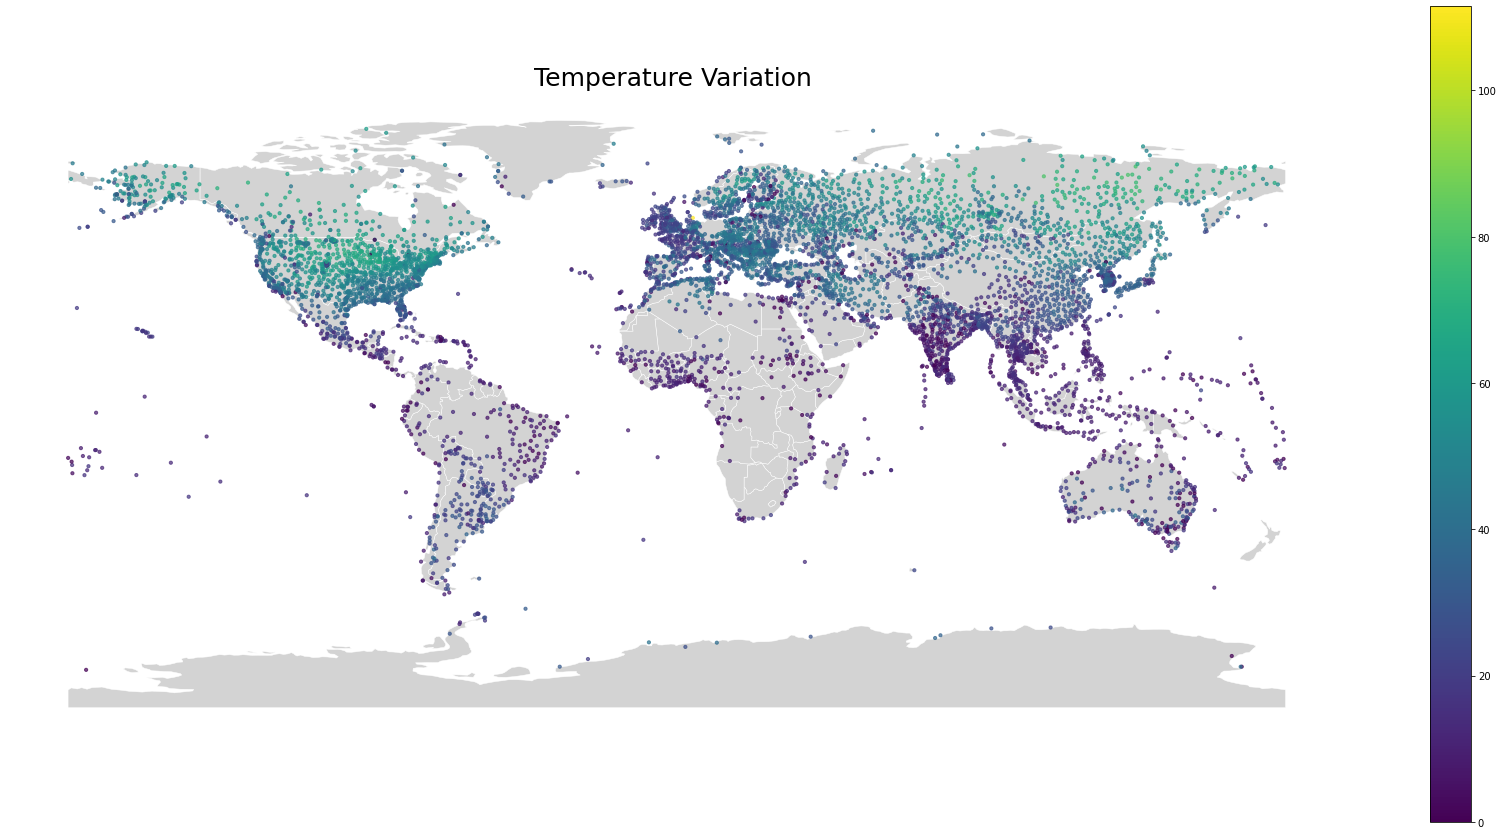

In [234]:
ax = world.plot(color='lightgrey', linewidth=0.5, edgecolor='white',figsize=(30,15))
ax.set_title("Temperature Variation ", fontsize=25)
gdf.plot(markersize=10, alpha=0.7, ax=ax,column='tem_diff',legend=True)
ax.axis('off')

(-197.99999999999997, 198.00000000000006, -98.6822565, 92.3273865)

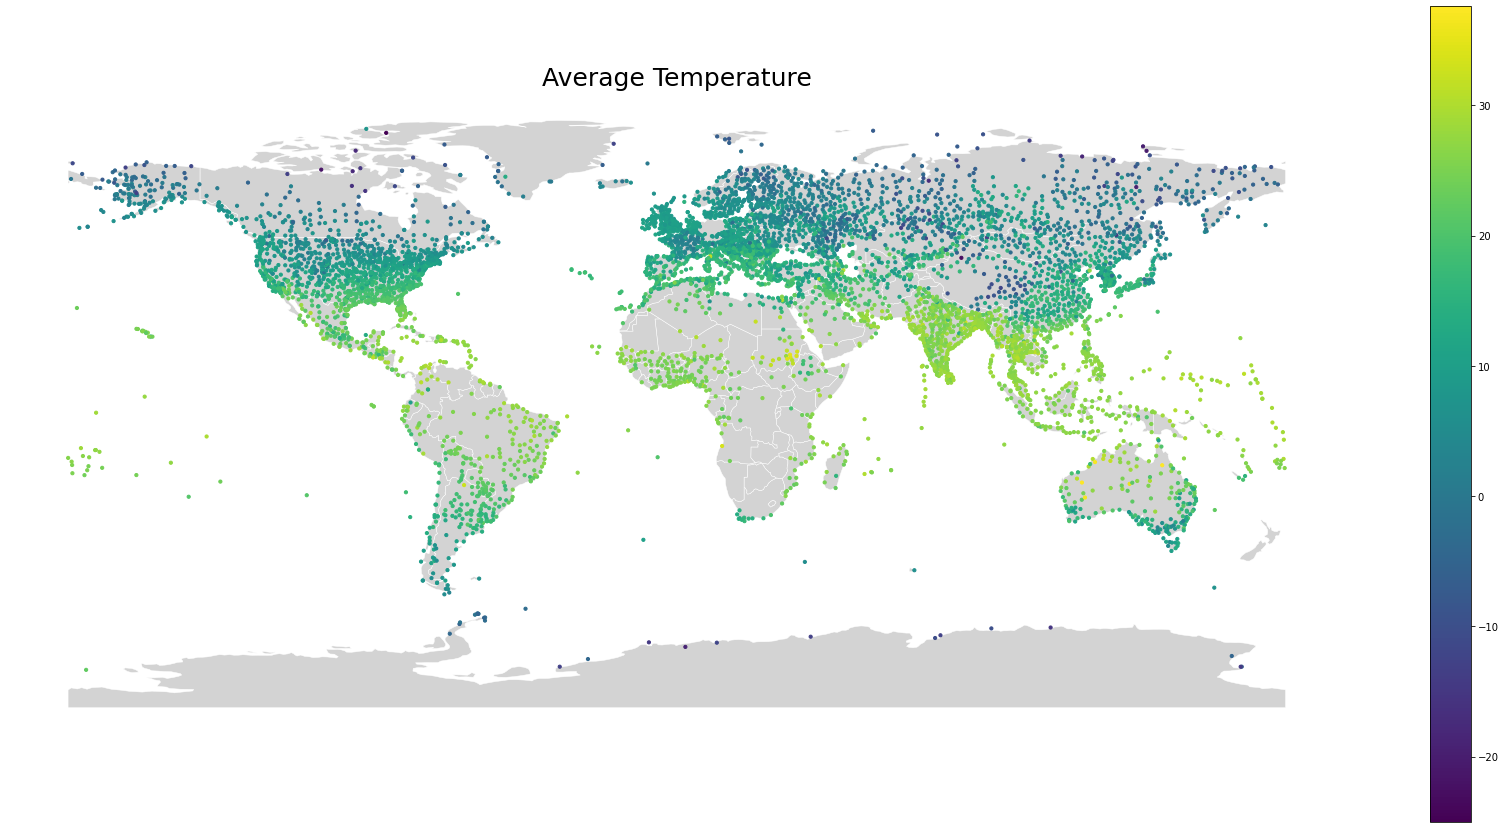

In [231]:
ax = world.plot(color='lightgrey', linewidth=0.5, edgecolor='white',figsize=(30,15))
ax.set_title("Average Temperature", fontsize=25)
gdf.plot(markersize=10, alpha=1, ax=ax,column='tem_avg',legend=True)
ax.axis('off')

(-197.99999999999997, 198.00000000000006, -98.6822565, 92.3273865)

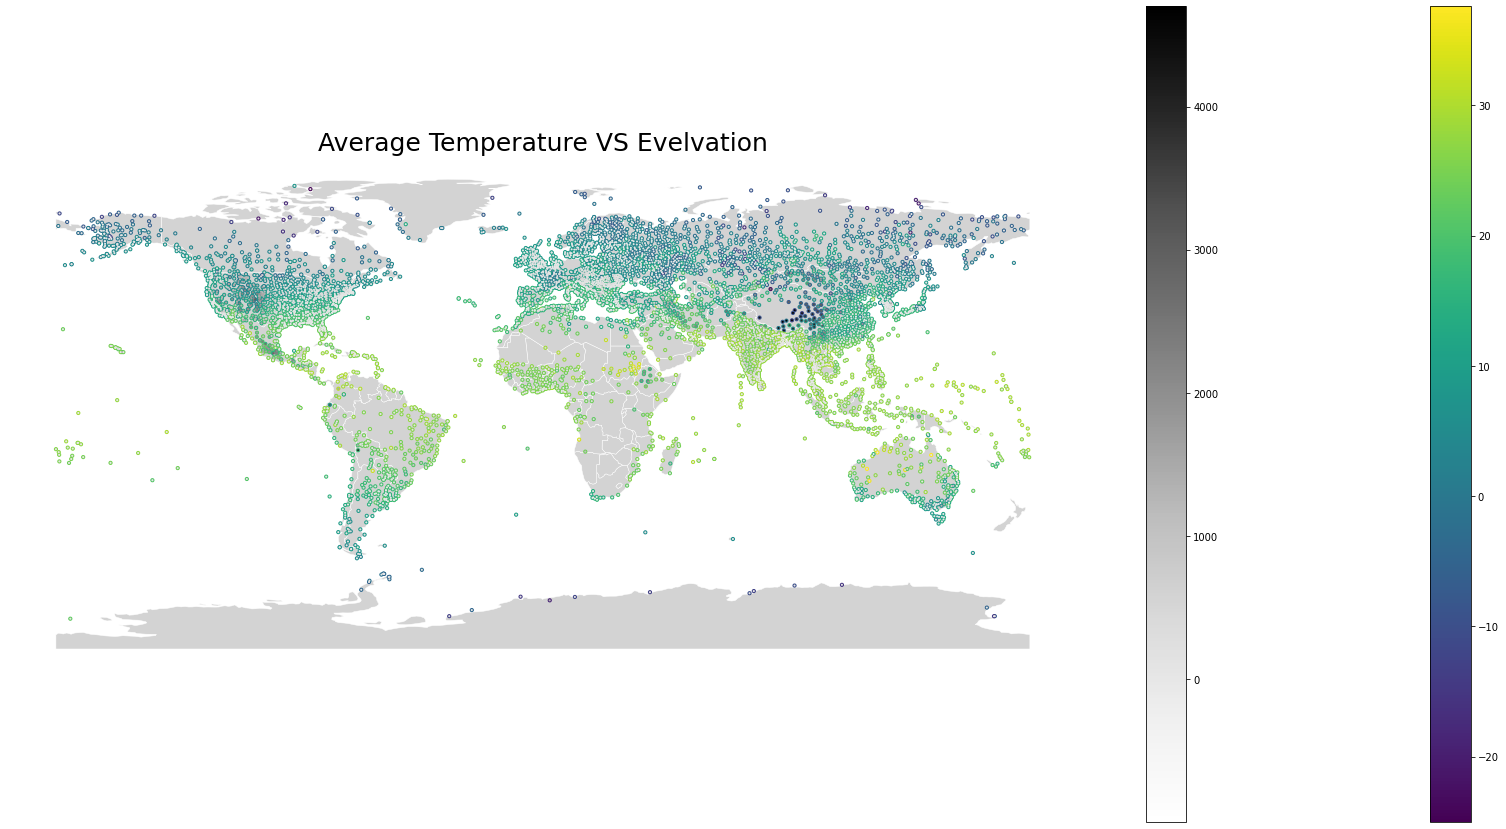

In [240]:
ax = world.plot(color='lightgrey', linewidth=0.5, edgecolor='white',figsize=(30,15))
ax.set_title("Average Temperature VS Evelvation", fontsize=25)
gdf.plot(markersize=10, alpha=1, ax=ax,column='tem_avg',legend=True)
gdf.plot(markersize=1, alpha=1, ax=ax,column='elevation',legend=True,cmap='Greys')
ax.axis('off')

In [305]:
gdf.shape

(6710, 16)

(-197.99999999999997, 198.00000000000006, -98.6822565, 92.3273865)

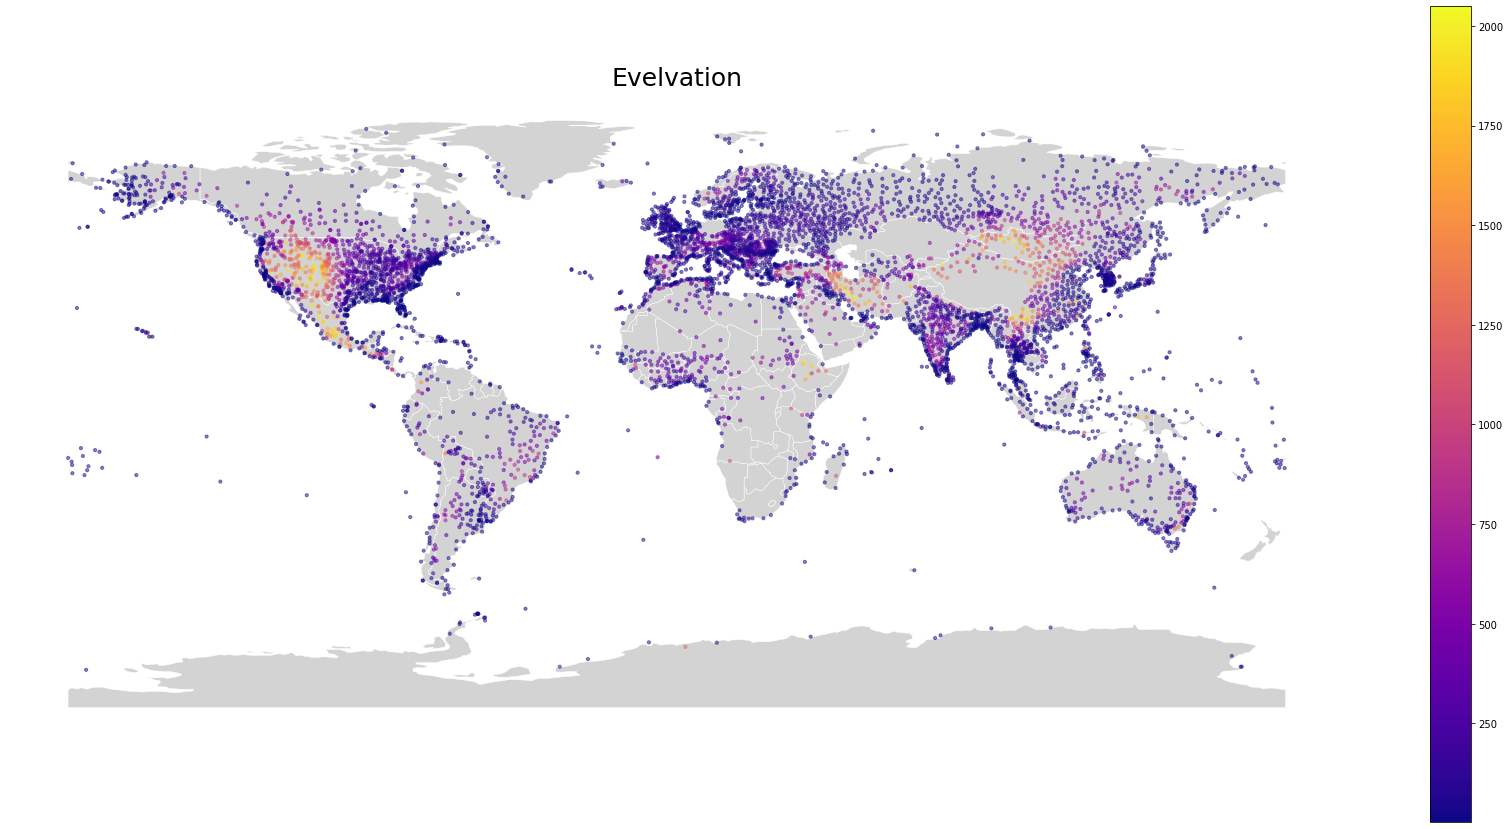

In [311]:
eve = gdf.sort_values(by=['elevation'], ascending=False).iloc[100:6500,]
ax = world.plot(color='lightgrey', linewidth=0.5, edgecolor='white',figsize=(30,15))
ax.set_title("Evelvation", fontsize=25)
eve.plot(markersize=10,marker='o', alpha=0.5, ax=ax,column='elevation',legend=True,cmap='plasma')
ax.axis('off')

In [278]:
# get top 20 station with highest avg
topavg_tem = gdf.sort_values(by=['tem_avg'], ascending=False).iloc[1:50,]
topvar_tem = gdf.sort_values(by=['tem_diff'], ascending=False).iloc[1:50,]

In [274]:
topavg_tem.head(2)
topvar_tem.head(2)

elevation   tem_avg   tem_diff  wind_avg  wind_diff       cig_avg  \
2100     235.83 -0.505983  80.300003  2.341880        7.0  22000.000000   
5218     138.00 -1.090000  80.000000  2.088889        6.0  15122.111111   

      cig_diff       vis_avg  vis_diff   liq_avg  liq_diff      slp_avg  \
2100       0.0  48495.726496   46000.0  0.005271  0.166667  1015.313675   
5218   21970.0  31809.722222   49950.0  0.013611  0.583333  1013.229445   

       slp_diff   dew_avg  dew_diff                    geometry  
2100  50.700012 -8.705983      10.2  POINT (108.53333 67.13333)  
5218  45.599976 -7.708889      10.1  POINT (133.40000 67.56667)

/home/hadoop/miniconda/lib/python3.7/site-packages/geopandas/plotting.py:509: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  "Only specify one of 'column' or 'color'. Using 'color'.", UserWarning
/home/hadoop/miniconda/lib/python3.7/site-packages/geopandas/plotting.py:509: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  "Only specify one of 'column' or 'color'. Using 'color'.", UserWarning


(-197.99999999999997, 198.00000000000006, -98.6822565, 92.3273865)

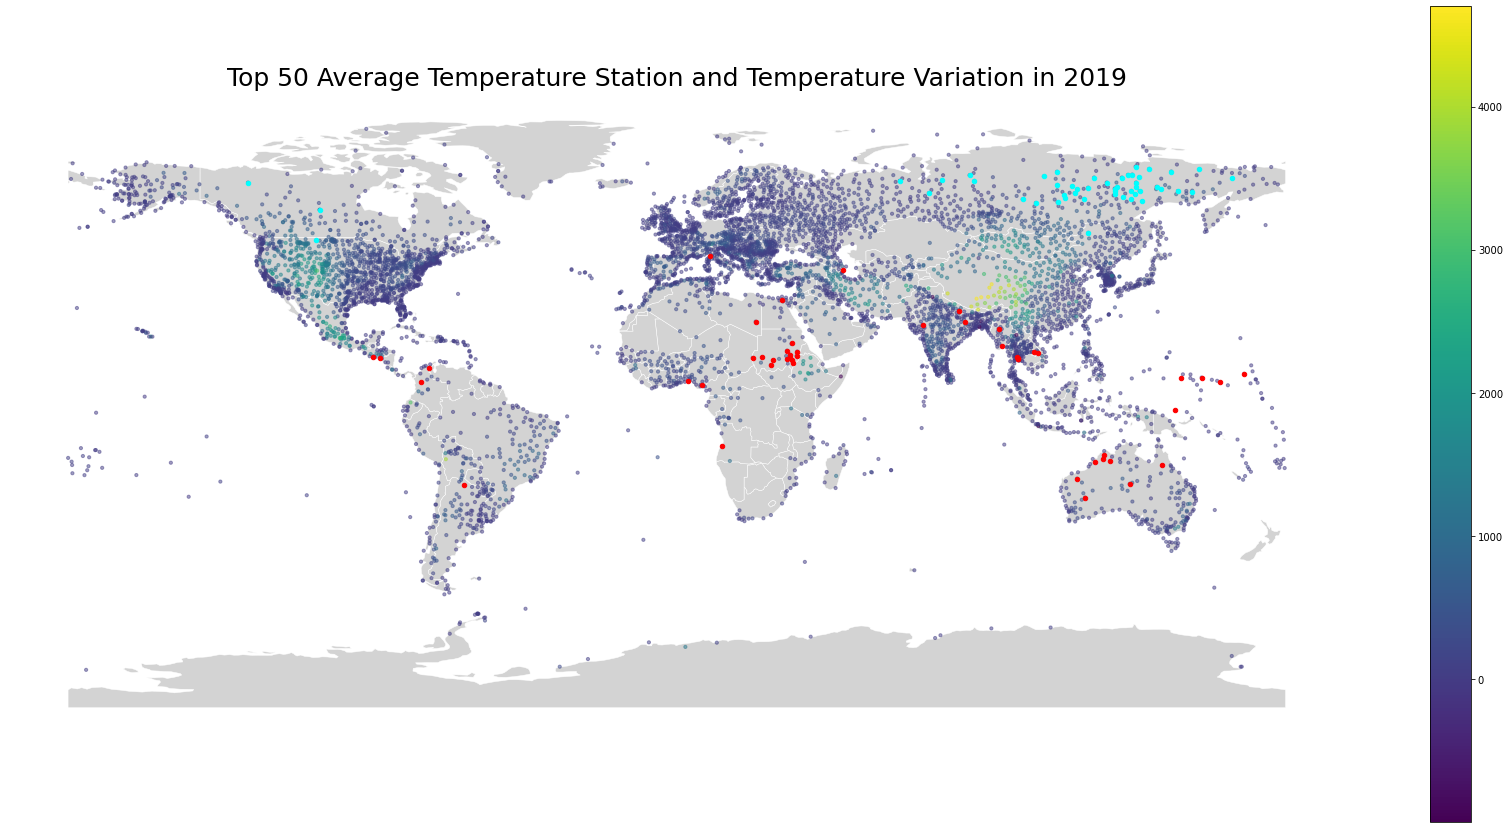

In [313]:
ax = world.plot(color='lightgrey', linewidth=0.5, edgecolor='white',figsize=(30,15))
ax.set_title("Top 50 Average Temperature Station and Temperature Variation in 2019", fontsize=25)
gdf.plot(markersize=10, alpha=0.5, ax=ax,column='elevation',legend=True)
topvar_tem.plot(markersize=20, ax=ax,column='tem_diff',color ='cyan' ,legend=True)
topavg_tem.plot(markersize=20, ax=ax,column='tem_avg',color='red',legend=True)
ax.axis('off')

(-197.99999999999997, 198.00000000000006, -98.6822565, 92.3273865)

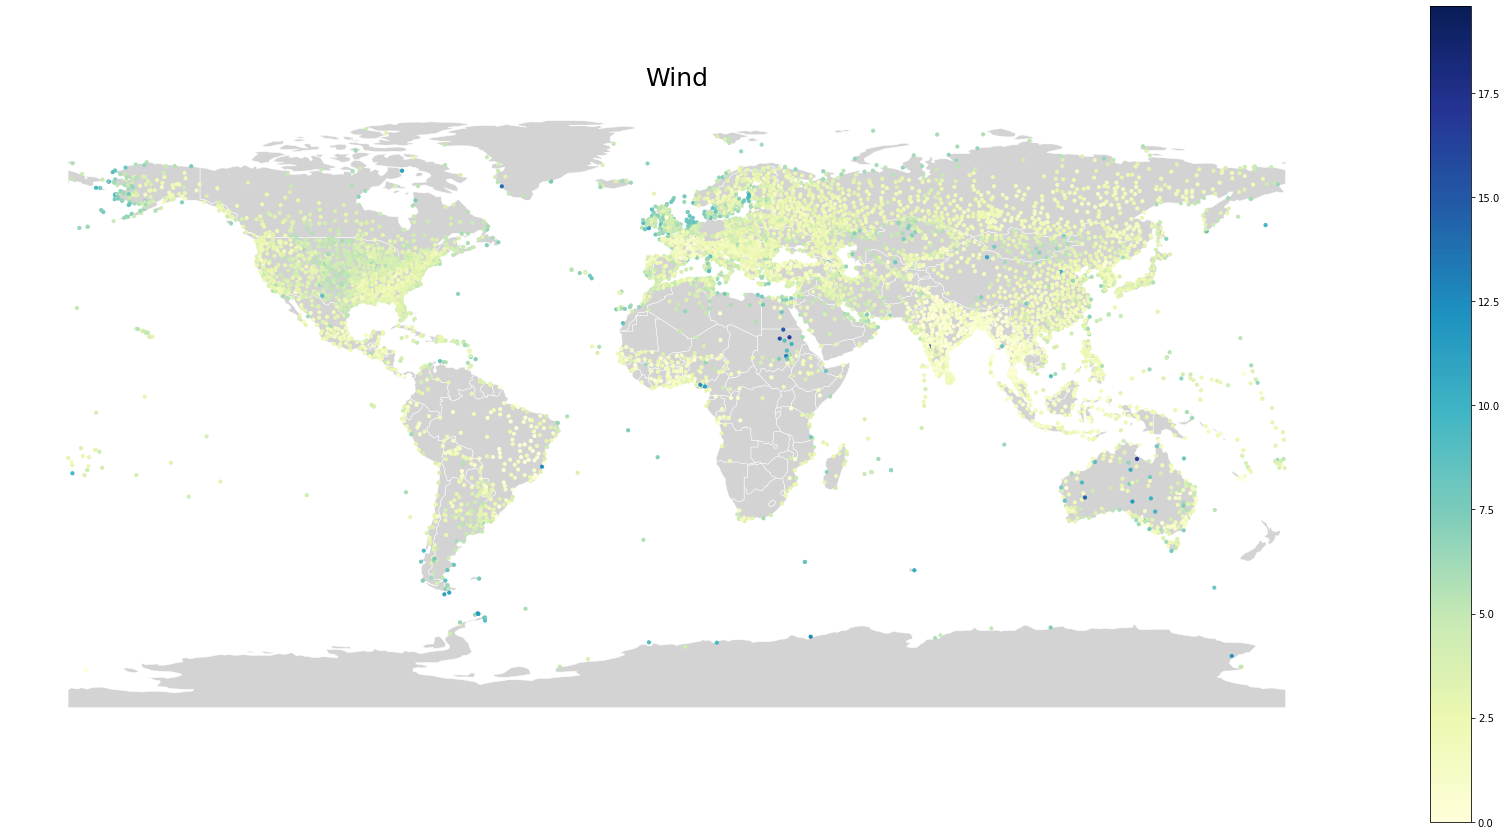

In [243]:
ax = world.plot(color='lightgrey', linewidth=0.5, edgecolor='white',figsize=(30,15))
ax.set_title("Wind", fontsize=25)
gdf.plot(markersize=10, alpha=1, ax=ax,column='wind_avg',legend=True,cmap='YlGnBu')
ax.axis('off')

(-197.99999999999997, 198.00000000000006, -98.6822565, 92.3273865)

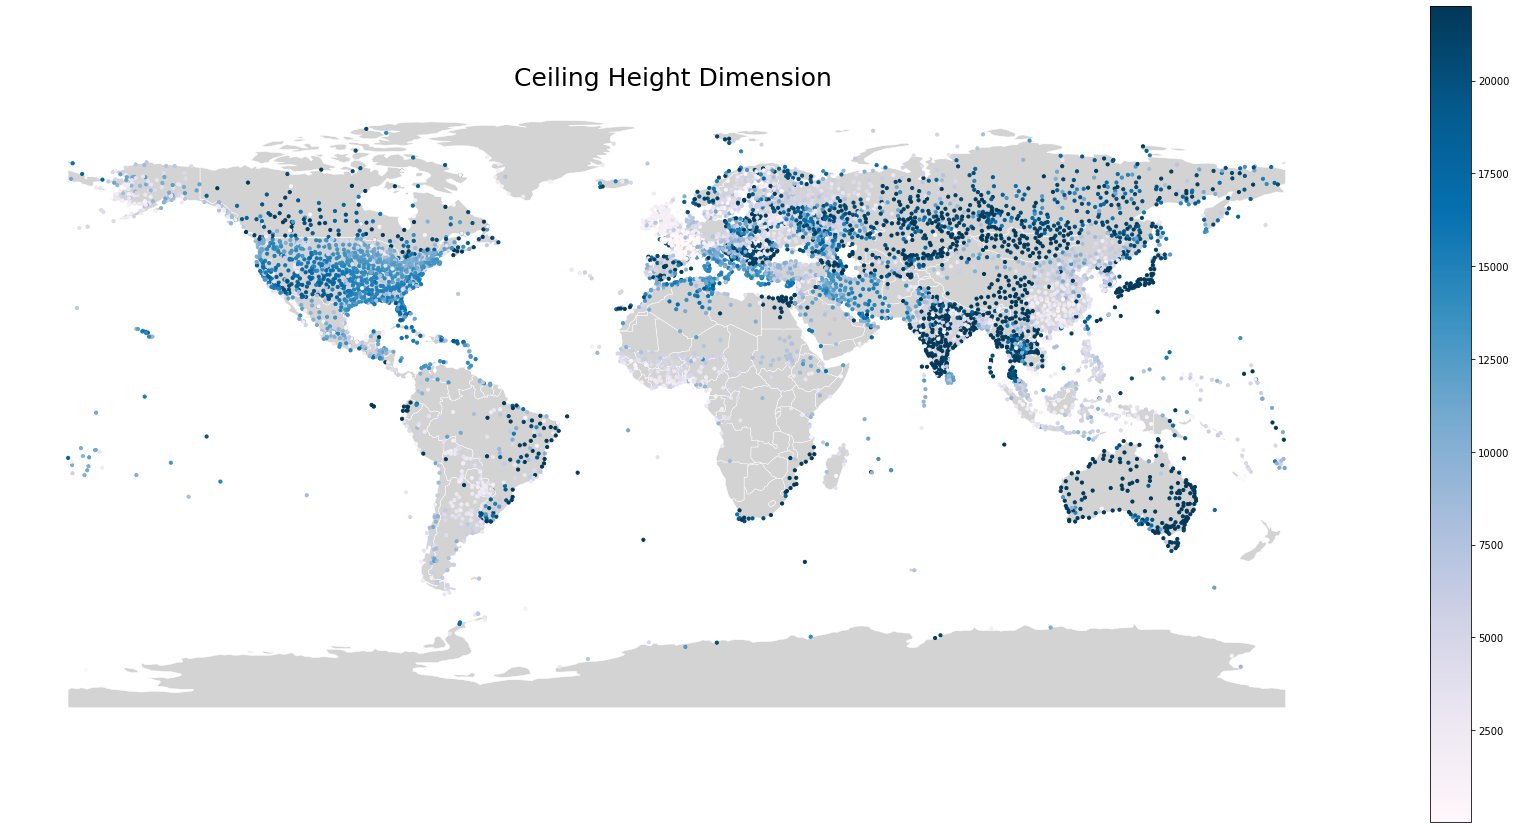

In [244]:
ax = world.plot(color='lightgrey', linewidth=0.5, edgecolor='white',figsize=(30,15))
ax.set_title("Ceiling Height Dimension ", fontsize=25)
gdf.plot(markersize=10, alpha=1, ax=ax,column='cig_avg',legend=True,cmap='PuBu')
ax.axis('off')

(-197.99999999999997, 198.00000000000006, -98.6822565, 92.3273865)

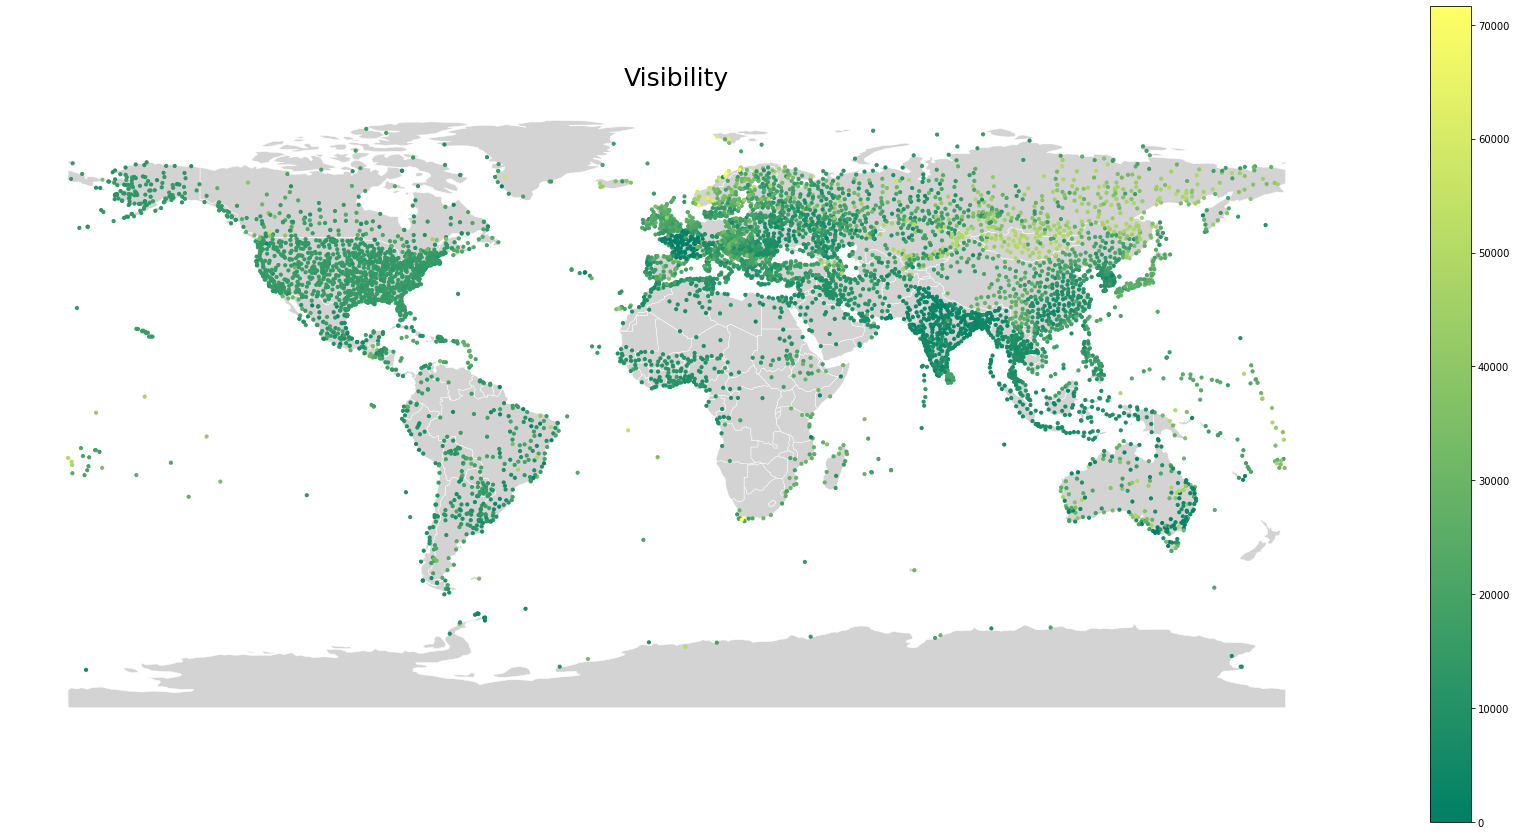

In [246]:
ax = world.plot(color='lightgrey', linewidth=0.5, edgecolor='white',figsize=(30,15))
ax.set_title("Visibility", fontsize=25)
gdf.plot(markersize=10, alpha=1, ax=ax,column='vis_avg',legend=True,cmap='summer')
ax.axis('off')

In [253]:
topliq_tem = gdf.sort_values(by=['liq_avg']).iloc[1:20,]

In [257]:
import mapclassify as mc
scheme = mc.Quantiles(gdf['liq_avg'], k=5)


/home/hadoop/miniconda/lib/python3.7/site-packages/mapclassify/classifiers.py:419: RuntimeWarning: invalid value encountered in greater
  binIds += (x > l) * (x <= r) * k
/home/hadoop/miniconda/lib/python3.7/site-packages/mapclassify/classifiers.py:419: RuntimeWarning: invalid value encountered in less_equal
  binIds += (x > l) * (x <= r) * k


In [287]:
# remove outliner and empty value
liqdf=gdf.dropna()
liqdf=liqdf.sort_values(by=['liq_avg']).iloc[1:6000,]
liqdf2=liqdf.sort_values(by=['liq_diff'], ascending=False).iloc[1:50,]

(-197.99999999999997, 198.00000000000006, -98.6822565, 92.3273865)

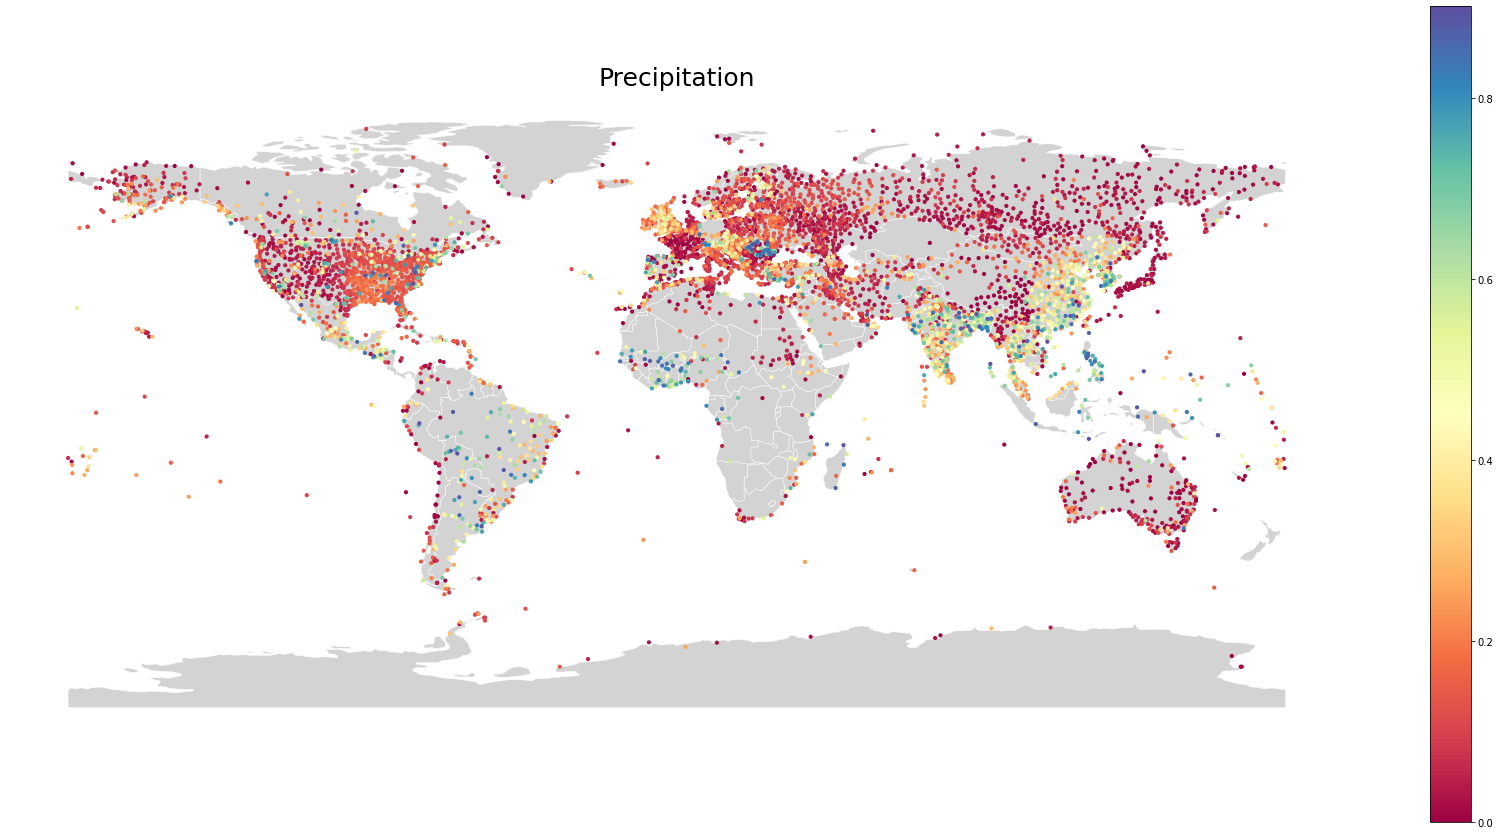

In [288]:
ax = world.plot(color='lightgrey', linewidth=0.5, edgecolor='white',figsize=(30,15))
ax.set_title("Precipitation", fontsize=25)
liqdf.plot(markersize=10, alpha=1, ax=ax,column='liq_avg',legend=True,cmap='Spectral')
ax.axis('off')

/home/hadoop/miniconda/lib/python3.7/site-packages/geopandas/plotting.py:509: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  "Only specify one of 'column' or 'color'. Using 'color'.", UserWarning


(-197.99999999999997, 198.00000000000006, -98.6822565, 92.3273865)

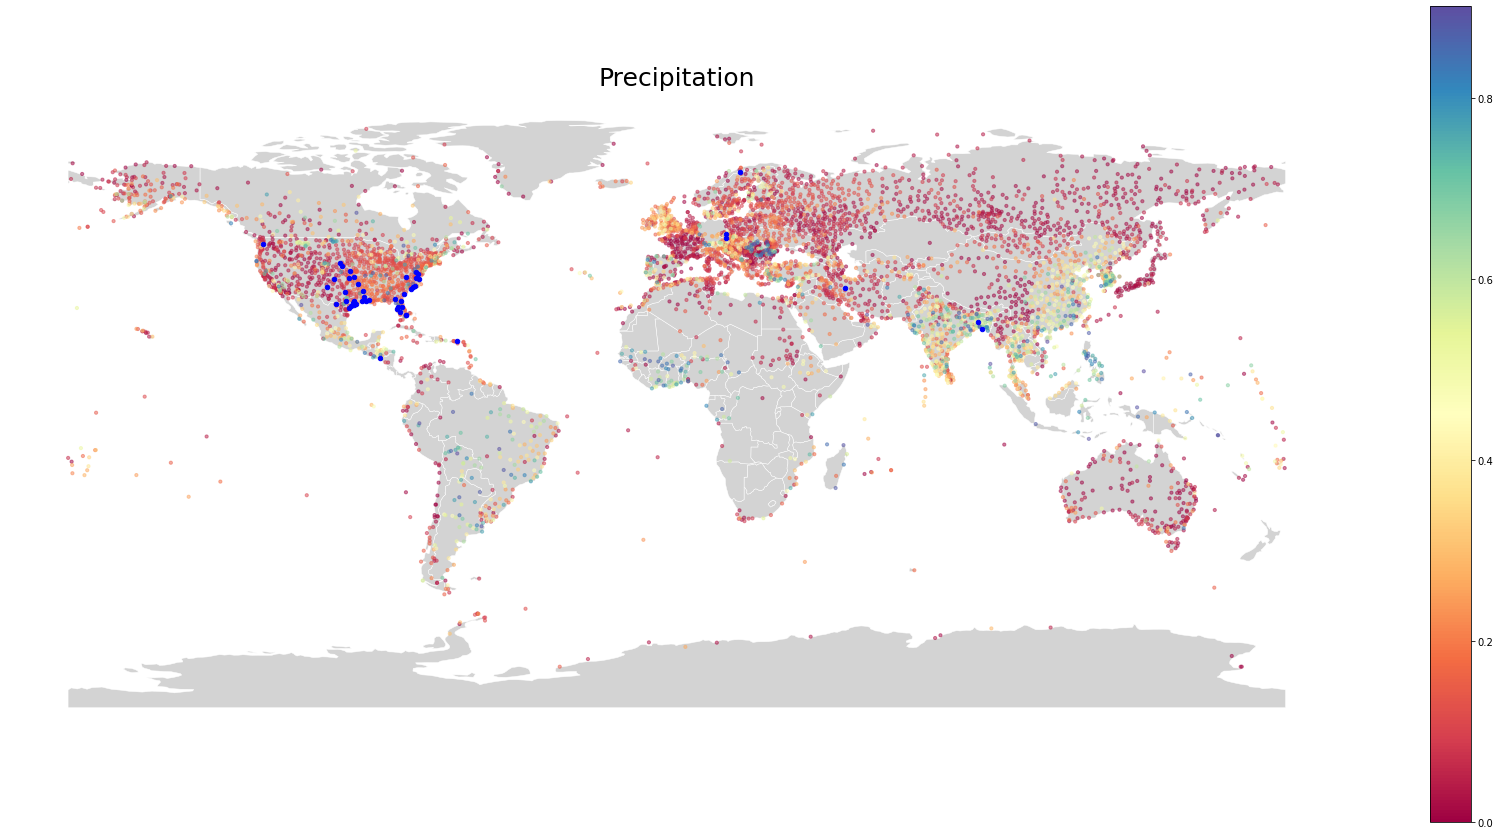

In [295]:
ax = world.plot(color='lightgrey', linewidth=0.5, edgecolor='white',figsize=(30,15))
ax.set_title("Precipitation", fontsize=25)
liqdf.plot(markersize=10, alpha=0.5, ax=ax,column='liq_avg',legend=True,cmap='Spectral')
liqdf2.plot(markersize=20, alpha=1, ax=ax,column='liq_avg',color='blue')
ax.axis('off')

/home/hadoop/miniconda/lib/python3.7/site-packages/geopandas/plotting.py:509: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  "Only specify one of 'column' or 'color'. Using 'color'.", UserWarning
/home/hadoop/miniconda/lib/python3.7/site-packages/geopandas/plotting.py:509: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  "Only specify one of 'column' or 'color'. Using 'color'.", UserWarning


(-197.99999999999997, 198.00000000000006, -98.6822565, 92.3273865)

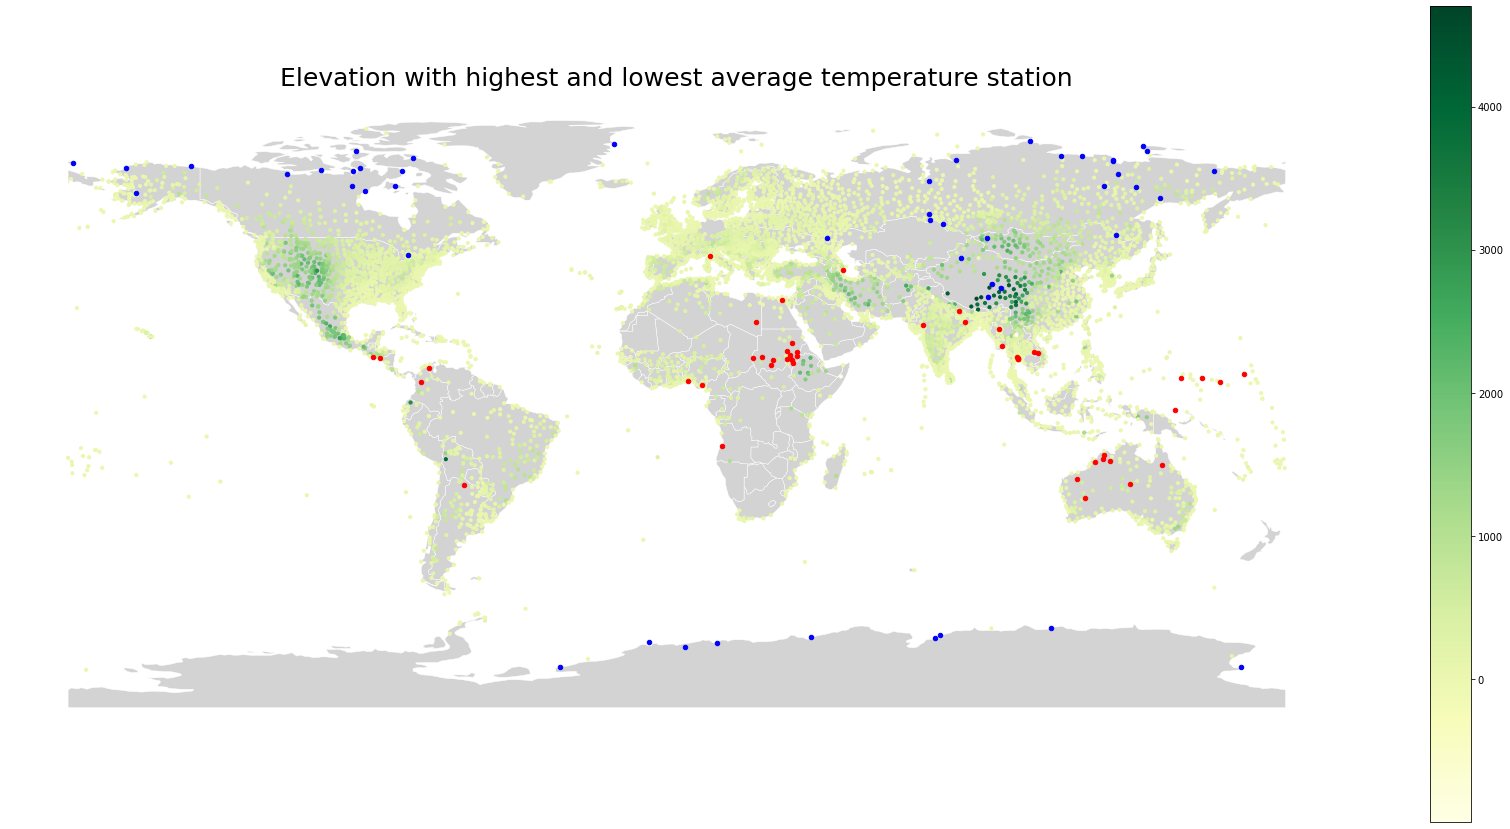

In [326]:
high_tem = gdf.sort_values(by=['tem_avg'], ascending=False).iloc[1:50,]
low_tem = gdf.sort_values(by=['tem_avg']).iloc[1:50,]
ax = world.plot(color='lightgrey', linewidth=0.5, edgecolor='white',figsize=(30,15))
ax.set_title("Elevation with highest and lowest average temperature station", fontsize=25)
gdf.plot(markersize=10, alpha=1, ax=ax,column='elevation',legend=True,cmap='YlGn')
high_tem.plot(markersize=20, alpha=1, ax=ax,column='tem_avg',color='red')
low_tem.plot(markersize=20, alpha=1, ax=ax,column='tem_avg',color='blue')
ax.axis('off')

/home/hadoop/miniconda/lib/python3.7/site-packages/geopandas/plotting.py:509: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  "Only specify one of 'column' or 'color'. Using 'color'.", UserWarning
/home/hadoop/miniconda/lib/python3.7/site-packages/geopandas/plotting.py:509: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  "Only specify one of 'column' or 'color'. Using 'color'.", UserWarning


(-197.99999999999997, 198.00000000000006, -98.6822565, 92.3273865)

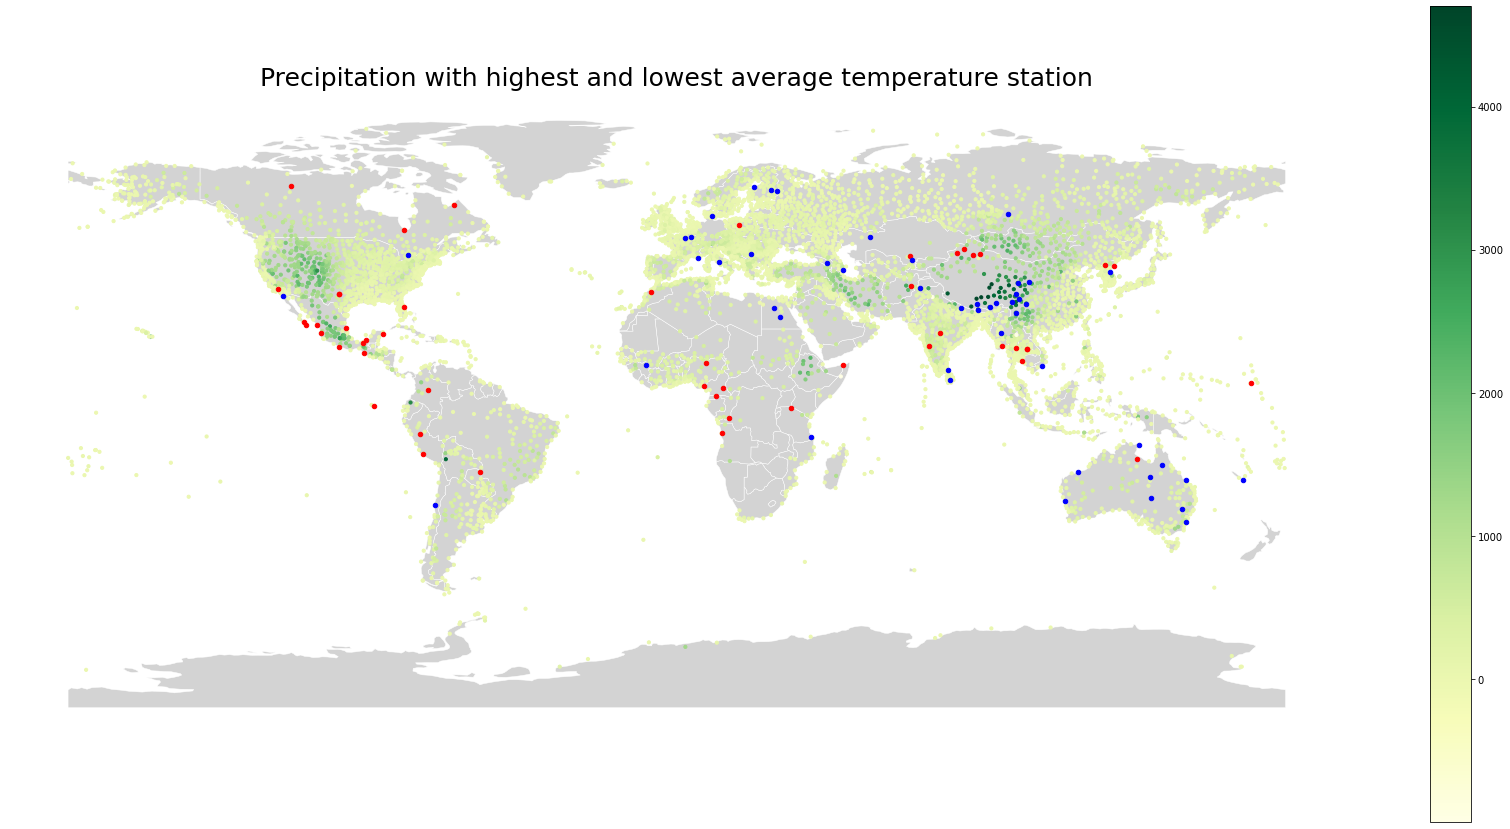

In [327]:
high_liq = gdf.sort_values(by=['liq_avg'], ascending=False).iloc[1:50,]
low_liq = gdf.sort_values(by=['liq_avg']).iloc[1:50,]
ax = world.plot(color='lightgrey', linewidth=0.5, edgecolor='white',figsize=(30,15))
ax.set_title("Precipitation with highest and lowest average temperature station", fontsize=25)
gdf.plot(markersize=10, alpha=1, ax=ax,column='elevation',legend=True,cmap='YlGn')
high_liq.plot(markersize=20, alpha=1, ax=ax,column='liq_avg',color='red')
low_liq.plot(markersize=20, alpha=1, ax=ax,column='liq_avg',color='blue')
ax.axis('off')

In [241]:
gdf.columns

Index(['elevation', 'tem_avg', 'tem_diff', 'wind_avg', 'wind_diff', 'cig_avg',
       'cig_diff', 'vis_avg', 'vis_diff', 'liq_avg', 'liq_diff', 'slp_avg',
       'slp_diff', 'dew_avg', 'dew_diff', 'geometry'],
      dtype='object')

(-197.99999999999997, 198.00000000000006, -98.6822565, 92.3273865)

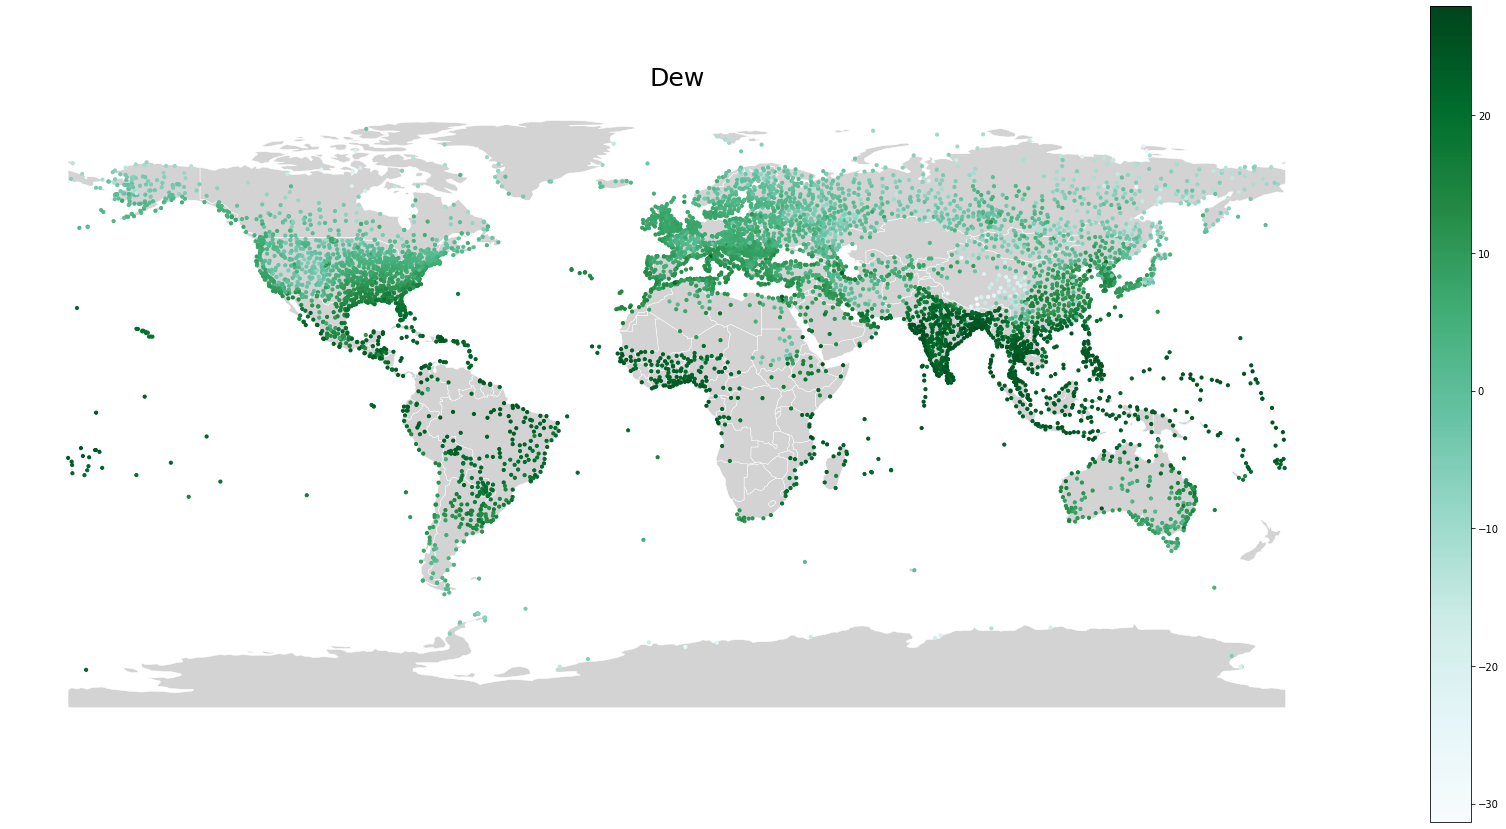

In [328]:
ax = world.plot(color='lightgrey', linewidth=0.5, edgecolor='white',figsize=(30,15))
ax.set_title("Dew", fontsize=25)
gdf.plot(markersize=10, alpha=1, ax=ax,column='dew_avg',legend=True,cmap='BuGn')
ax.axis('off')

(-197.99999999999997, 198.00000000000006, -98.6822565, 92.3273865)

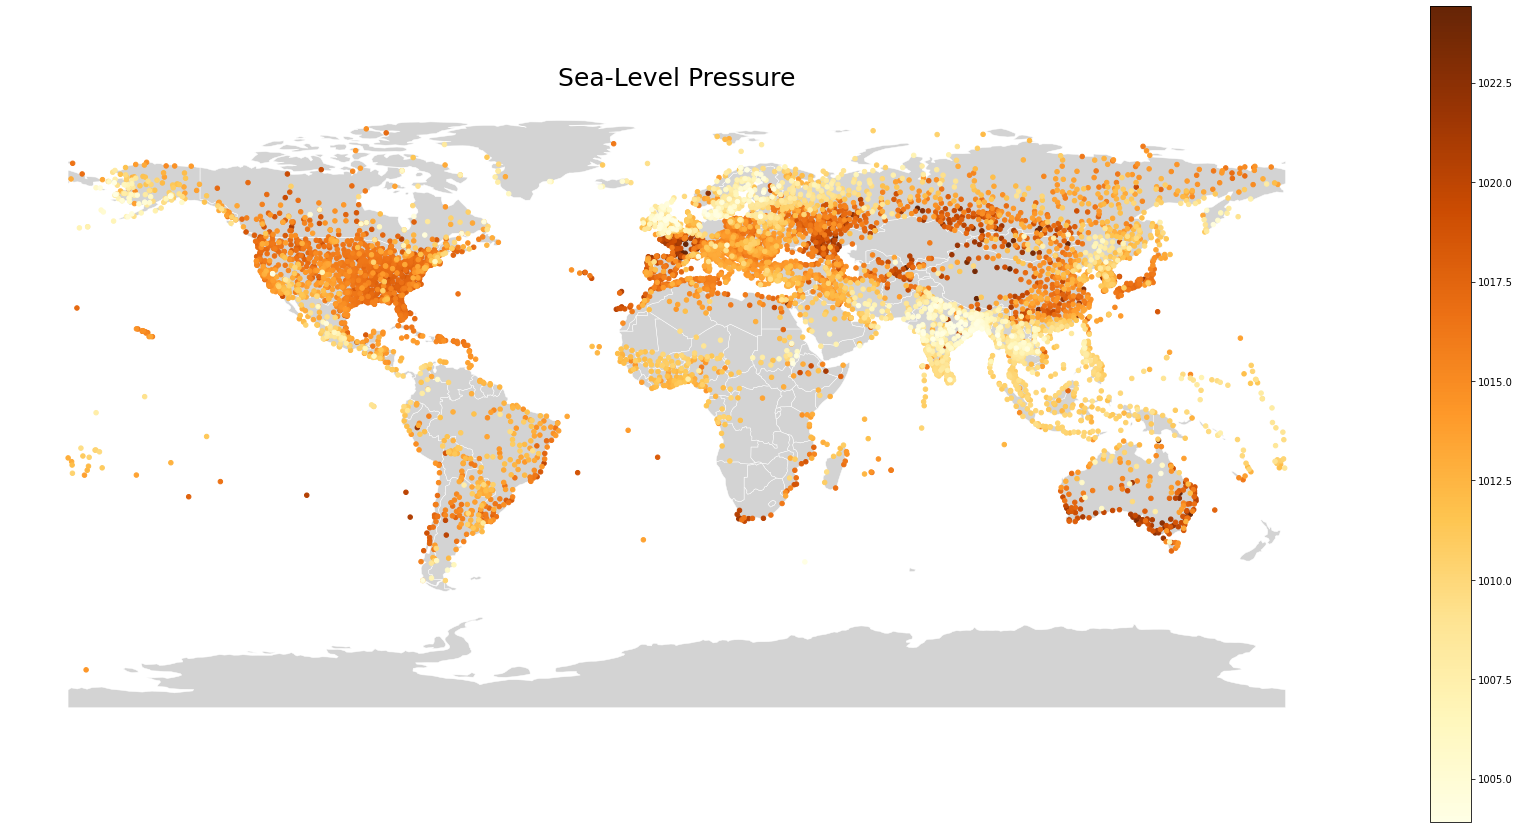

In [332]:
slp = gdf.sort_values(by=['slp_avg'], ascending=False).iloc[100:6500,]
ax = world.plot(color='lightgrey', linewidth=0.5, edgecolor='white',figsize=(30,15))
ax.set_title("Sea-Level Pressure", fontsize=25)
slp.plot(markersize=20, alpha=1, ax=ax,column='slp_avg',legend=True,cmap='YlOrBr')
ax.axis('off')

### Correlation heatmap

In [334]:
import matplotlib.pyplot as plt
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation

In [363]:
#compute the correlation matrix
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=['elevation','temp', 'cig','wind', 'vis', 'liquid', 'slp','dew'], 
                            outputCol=vector_col)
df_vector = assembler.transform(df).select(vector_col)
matrix = Correlation.corr(df_vector, vector_col).collect()[0][0]
corrmatrix = matrix.toArray().tolist()

In [364]:
print(corrmatrix)

[[1.0,
  -0.17439708405114185,
  0.13704378617530016,
  -0.012899779980143708,
  0.11691132714340215,
  -0.02386883690921053,
  0.1833919496625477,
  -0.30956848078319105],
 [-0.17439708405114185,
  1.0,
  0.038932909066176254,
  -0.2341227840909104,
  -0.29232828544021694,
  0.1336758575618406,
  -0.18414726440808307,
  0.9297865178743666],
 [0.13704378617530016,
  0.038932909066176254,
  1.0,
  -0.11393422119590556,
  0.31227079781917266,
  -0.16636062423282222,
  0.2286491697516894,
  -0.14449367216921197],
 [-0.012899779980143708,
  -0.2341227840909104,
  -0.11393422119590556,
  1.0,
  0.11281899310989654,
  -0.03772424343524036,
  -0.07192398849022644,
  -0.2636652021658527],
 [0.11691132714340215,
  -0.29232828544021694,
  0.31227079781917266,
  0.11281899310989654,
  1.0,
  -0.08950237487713836,
  0.09940163112483522,
  -0.37207796659356857],
 [-0.02386883690921053,
  0.1336758575618406,
  -0.16636062423282222,
  -0.03772424343524036,
  -0.08950237487713836,
  1.0,
  -0.14967853

In [367]:
# convert matrix to df
# not necessary, just try
corrdf = spark.createDataFrame(corrmatrix,['elevation','temp', 'cig','wind', 'vis', 'liquid', 'slp','dew'])
corrdf.show()

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|           elevation|                temp|                 cig|                wind|                 vis|              liquid|                 slp|                 dew|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|                 1.0|-0.17439708405114185| 0.13704378617530016|-0.01289977998014...| 0.11691132714340215|-0.02386883690921053|  0.1833919496625477|-0.30956848078319105|
|-0.17439708405114185|                 1.0|0.038932909066176254| -0.2341227840909104|-0.29232828544021694|  0.1336758575618406|-0.18414726440808307|  0.9297865178743666|
| 0.13704378617530016|0.038932909066176254|                 1.0|-0.11393422119590556| 0.31227079781917266|-0.16636062423282222|  0.2286491697516894|-0

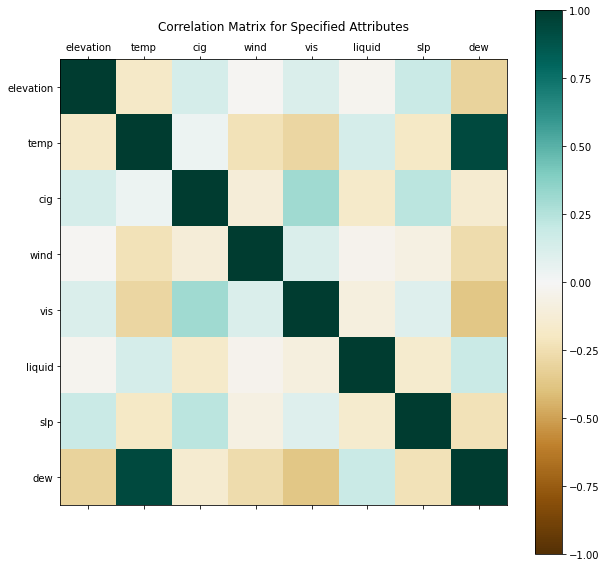

In [379]:
def plot_corr_matrix(correlations,attr):
    fig=plt.figure(figsize=(10,10))
    ax=fig.add_subplot(111)
    ax.set_title("Correlation Matrix for Specified Attributes")
    ax.set_xticklabels(['']+attr)
    ax.set_yticklabels(['']+attr)
    cax=ax.matshow(correlations,vmax=1,vmin=-1,cmap='BrBG')
    fig.colorbar(cax)
    plt.show()

plot_corr_matrix(corrmatrix,['elevation','temp', 'cig','wind', 'vis', 'liquid', 'slp','dew'])

### Scatter Plot for Highly Correlation variables

In [395]:
# using average data of each station to create scatter plot
dew_l = [int(row['avg(dew)']) for row in comp.collect()]
temp_l = [int(row['avg(temp)']) for row in comp.collect()]
eve_l = [int(row['elevation']) for row in comp.collect()]
liq_l = [int(row['avg(liquid)']) for row in comp.collect()]

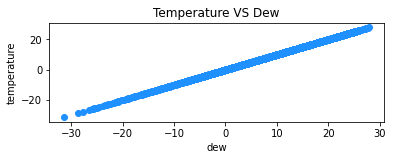

In [398]:
plt.figure(1)
plt.subplot(211)
plt.title("Temperature VS Dew")
plt.xlabel("dew")
plt.ylabel("temperature")
plt.scatter(dew_l,temp_l,color='dodgerblue')

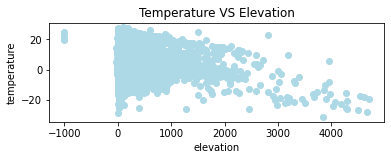

In [399]:
plt.figure(1)
plt.subplot(211)
plt.title("Temperature VS Elevation")
plt.xlabel("elevation")
plt.ylabel("temperature")
plt.scatter(eve_l,liq_l,color='lightblue')

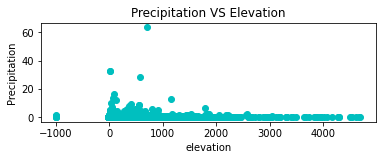

In [403]:
plt.figure(1)
plt.subplot(211)
plt.title("Precipitation VS Elevation")
plt.xlabel("elevation")
plt.ylabel("Precipitation")
plt.scatter(eve_l,liq_l,color='c')

In [406]:
sc.stop()